# On the Unbalanced Data (Middle Level)

## 1. Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision
import random

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from collections import defaultdict

### 1.1 Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

## confusion matrix
confusion_ce = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_l1 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal2 = np.zeros((NUM_CLASS, NUM_CLASS))
confusion_focal05 = np.zeros((NUM_CLASS, NUM_CLASS))

### 1.2 Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### 1.3 Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)


test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### 1.4 Creating an Unbalanced Training Set

In [5]:

samples_per_class = {
    0: 4000,
    1: 3500,
    2: 300,
    3: 500,
    4: 200,
    5: 100,
    6: 500,
    7: 200,
    8: 250,
    9: 100
}



samples_grouped_by_class = defaultdict(list)
for sample in train_set:
    label = sample[1]
    samples_grouped_by_class[label].append(sample)


selected_samples = []
for label, count in samples_per_class.items():
    selected_samples.extend(random.sample(samples_grouped_by_class[label], count))

train_set = selected_samples

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## 2. Model

## 2.1 Define the Neural Network

In [6]:
## this is the model for Cross Entropy, since nn.crossentropy is equipped with a softmax layer, here we do not employ a softmax layer
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 

        return x


In [7]:
## define a model which has a softmax layer as the last layer, which is significant when considering L1 Loss and Focal Loss

class ConvNet_DIY(nn.Module):
    def __init__(self):
        super(ConvNet_DIY, self).__init__()
        
        # First block
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second block
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 
        x = nn.Softmax(dim=1)(x) 
        return x


### 2.2 Define the Loss Functions and train_batch, testing_batch

In [8]:
# Define Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        
        eps = 1e-6
        probs = inputs.clamp(eps, 1. - eps)
        
        # calculate the loss of each class
        class_loss = -targets * torch.log(probs) * self.alpha * (1 - probs)**self.gamma
        
        # sum up
        loss = class_loss.sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [9]:
##################### Define the 4 required Loss Functions##################
CrossEntropy = nn.CrossEntropyLoss()
L1Loss = nn.L1Loss()
FocalLoss_05 = FocalLoss(gamma=0.5)
FocalLoss_2 = FocalLoss(gamma=2)
###############################################################

In [10]:
def train_batch(model, image, target, loss_fn):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.
        loss_fn (torch.nn.Module, optional): Loss function to compute the loss.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function.
    """
    
    output = model(image) 
    loss = loss_fn(output, target)

    return output, loss

In [11]:
def test_batch(model, image, target, loss_fn):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image) 
    loss = loss_fn(output, target)
    ###############################################################

    return output, loss

## 3.  Model Training with Different Loss Functions

### 3.1 CrossEntropy

In [12]:
## initial the model for Cross Entropy

model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss_CE = []
training_acc_CE = []
testing_loss_CE = []
testing_acc_CE = []

all_targets = []
all_preds = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target, CrossEntropy)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
          
    training_loss_CE.append(epoch_loss)
    training_acc_CE.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target, CrossEntropy)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
        

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_CE.append(val_loss)
        testing_acc_CE.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_CE = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_CE, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0117 Acc: 0.5684
Begin test......
Test Loss: 0.0210 Acc: 0.1625
Epoch: 2/30 Train Loss: 0.0084 Acc: 0.6480
Begin test......
Test Loss: 0.0183 Acc: 0.2490
Epoch: 3/30 Train Loss: 0.0076 Acc: 0.6878
Begin test......
Test Loss: 0.0202 Acc: 0.2333
Epoch: 4/30 Train Loss: 0.0073 Acc: 0.6987
Begin test......
Test Loss: 0.0190 Acc: 0.2785
Epoch: 5/30 Train Loss: 0.0068 Acc: 0.7259
Begin test......
Test Loss: 0.0179 Acc: 0.2827
Epoch: 6/30 Train Loss: 0.0059 Acc: 0.7533
Begin test......
Test Loss: 0.0174 Acc: 0.3393
Epoch: 7/30 Train Loss: 0.0056 Acc: 0.7687
Begin test......
Test Loss: 0.0163 Acc: 0.3434
Epoch: 8/30 Train Loss: 0.0053 Acc: 0.7819
Begin test......
Test Loss: 0.0165 Acc: 0.3353
Epoch: 9/30 Train Loss: 0.0051 Acc: 0.7917
Begin test......
Test Loss: 0.0179 Acc: 0.3481
Epoch: 10/30 Train Loss: 0.0048 Acc: 0.7987
Begin test......
Test Loss: 0.0161 Acc: 0.3686
Epoch: 11/30 Train Loss: 0.0043 Acc: 0.8226
Begin test......
Test Loss: 0.0179 Acc: 0.3511
Epoch: 1

In [14]:
confusion_ce = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_ce, recall_ce, f1_ce, _ce = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_ce = np.mean(precision_ce)
macro_recall_ce = np.mean(recall_ce)
macro_f1_ce = np.mean(f1_ce)
micro_precision_ce, micro_recall_ce, micro_f1_ce, _ce = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_ce:.4f} Macro Recall: {macro_recall_ce:.4f} Macro F1: {macro_f1_ce:.4f}')
print(f'Micro Precision: {micro_precision_ce:.4f} Micro Recall: {micro_recall_ce:.4f} Micro F1: {micro_f1_ce:.4f}')

Macro Precision: 0.4508 Macro Recall: 0.3590 Macro F1: 0.2990
Micro Precision: 0.3590 Micro Recall: 0.3590 Micro F1: 0.3590


### 3.2 L1Loss

In [15]:
## initial the model for L1 Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
## to adjust "target" to one-hot vector

def to_one_hot(targets, num_classes):
    one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
    one_hot.scatter_(1, targets.unsqueeze(1), 1.)
    return one_hot

In [17]:
training_loss_L1 = []
training_acc_L1 = []
testing_loss_L1 = []
testing_acc_L1 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, L1Loss)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_L1.append(epoch_loss)
    training_acc_L1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, L1Loss)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_L1.append(val_loss)
        testing_acc_L1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_L1 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_L1, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0007 Acc: 0.5473
Begin test......
Test Loss: 0.0013 Acc: 0.1612
Epoch: 2/30 Train Loss: 0.0006 Acc: 0.6311
Begin test......
Test Loss: 0.0013 Acc: 0.1723
Epoch: 3/30 Train Loss: 0.0006 Acc: 0.6427
Begin test......
Test Loss: 0.0013 Acc: 0.1739
Epoch: 4/30 Train Loss: 0.0006 Acc: 0.6483
Begin test......
Test Loss: 0.0013 Acc: 0.1654
Epoch: 5/30 Train Loss: 0.0005 Acc: 0.6530
Begin test......
Test Loss: 0.0013 Acc: 0.1669
Epoch: 6/30 Train Loss: 0.0005 Acc: 0.6707
Begin test......
Test Loss: 0.0013 Acc: 0.1768
Epoch: 7/30 Train Loss: 0.0005 Acc: 0.6825
Begin test......
Test Loss: 0.0013 Acc: 0.1768
Epoch: 8/30 Train Loss: 0.0005 Acc: 0.6904
Begin test......
Test Loss: 0.0013 Acc: 0.1809
Epoch: 9/30 Train Loss: 0.0005 Acc: 0.6964
Begin test......
Test Loss: 0.0013 Acc: 0.1811
Epoch: 10/30 Train Loss: 0.0005 Acc: 0.6973
Begin test......
Test Loss: 0.0013 Acc: 0.1790
Epoch: 11/30 Train Loss: 0.0005 Acc: 0.7066
Begin test......
Test Loss: 0.0013 Acc: 0.1829
Epoch: 1

In [18]:
confusion_l1 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_l1, recall_l1, f1_l1, _l1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_l1 = np.mean(precision_l1)
macro_recall_l1 = np.mean(recall_l1)
macro_f1_l1 = np.mean(f1_l1)
micro_precision_l1, micro_recall_l1, micro_f1_l1, _l1 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_l1:.4f} Macro Recall: {macro_recall_l1:.4f} Macro F1: {macro_f1_l1:.4f}')
print(f'Micro Precision: {micro_precision_l1:.4f} Micro Recall: {micro_recall_l1:.4f} Micro F1: {micro_f1_l1:.4f}')

Macro Precision: 0.8390 Macro Recall: 0.1801 Macro F1: 0.0633
Micro Precision: 0.1801 Micro Recall: 0.1801 Micro F1: 0.1801


### 3.3 Focal Loss with $\gamma$ = 2

In [19]:
## initial the model for Focal Loss

model = ConvNet_DIY()

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [20]:
training_loss_Focal2 = []
training_acc_Focal2 = []
testing_loss_Focal2 = []
testing_acc_Focal2 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_2)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal2.append(epoch_loss)
    training_acc_Focal2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_2)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal2.append(val_loss)
        testing_acc_Focal2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal2 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal2, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0065 Acc: 0.6015
Begin test......
Test Loss: 0.0168 Acc: 0.2120
Epoch: 2/30 Train Loss: 0.0048 Acc: 0.6754
Begin test......
Test Loss: 0.0146 Acc: 0.2603
Epoch: 3/30 Train Loss: 0.0040 Acc: 0.7147
Begin test......
Test Loss: 0.0135 Acc: 0.2937
Epoch: 4/30 Train Loss: 0.0037 Acc: 0.7424
Begin test......
Test Loss: 0.0114 Acc: 0.3709
Epoch: 5/30 Train Loss: 0.0033 Acc: 0.7602
Begin test......
Test Loss: 0.0108 Acc: 0.3596
Epoch: 6/30 Train Loss: 0.0028 Acc: 0.7943
Begin test......
Test Loss: 0.0122 Acc: 0.3506
Epoch: 7/30 Train Loss: 0.0026 Acc: 0.8047
Begin test......
Test Loss: 0.0099 Acc: 0.3933
Epoch: 8/30 Train Loss: 0.0024 Acc: 0.8199
Begin test......
Test Loss: 0.0102 Acc: 0.4097
Epoch: 9/30 Train Loss: 0.0022 Acc: 0.8268
Begin test......
Test Loss: 0.0097 Acc: 0.4211
Epoch: 10/30 Train Loss: 0.0021 Acc: 0.8388
Begin test......
Test Loss: 0.0100 Acc: 0.4106
Epoch: 11/30 Train Loss: 0.0018 Acc: 0.8588
Begin test......
Test Loss: 0.0098 Acc: 0.4254
Epoch: 1

In [21]:
confusion_focal2 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal2, recall_focal2, f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal2 = np.mean(precision_focal2)
macro_recall_focal2 = np.mean(recall_focal2)
macro_f1_focal2 = np.mean(f1_focal2)
micro_precision_focal2, micro_recall_focal2, micro_f1_focal2, _focal2 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal2:.4f} Macro Recall: {macro_recall_focal2:.4f} Macro F1: {macro_f1_focal2:.4f}')
print(f'Micro Precision: {micro_precision_focal2:.4f} Micro Recall: {micro_recall_focal2:.4f} Micro F1: {micro_f1_focal2:.4f}')

Macro Precision: 0.5268 Macro Recall: 0.4044 Macro F1: 0.3554
Micro Precision: 0.4044 Micro Recall: 0.4044 Micro F1: 0.4044


### 3.4 Focal Loss with $\gamma = 0.5$

In [22]:
## initial the model for Focal Loss

model = ConvNet_DIY()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE/10, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [23]:
training_loss_Focal05 = []
training_acc_Focal05 = []
testing_loss_Focal05 = []
testing_acc_Focal05 = []

all_targets = []
all_preds = []


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = to_one_hot(target, NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target_one_hot, FocalLoss_05)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_Focal05.append(epoch_loss)
    training_acc_Focal05.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)
            target_one_hot = to_one_hot(target, NUM_CLASS)

            # test model
            outputs, loss = test_batch(model, image, target_one_hot, FocalLoss_05)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_Focal05.append(val_loss)
        testing_acc_Focal05.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state_Focal05 = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state_Focal05, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0084 Acc: 0.6064
Begin test......
Test Loss: 0.0197 Acc: 0.1961
Epoch: 2/30 Train Loss: 0.0065 Acc: 0.6836
Begin test......
Test Loss: 0.0161 Acc: 0.2828
Epoch: 3/30 Train Loss: 0.0057 Acc: 0.7267
Begin test......
Test Loss: 0.0172 Acc: 0.2909
Epoch: 4/30 Train Loss: 0.0051 Acc: 0.7532
Begin test......
Test Loss: 0.0150 Acc: 0.3480
Epoch: 5/30 Train Loss: 0.0046 Acc: 0.7738
Begin test......
Test Loss: 0.0155 Acc: 0.3374
Epoch: 6/30 Train Loss: 0.0041 Acc: 0.7989
Begin test......
Test Loss: 0.0143 Acc: 0.3693
Epoch: 7/30 Train Loss: 0.0038 Acc: 0.8134
Begin test......
Test Loss: 0.0141 Acc: 0.3846
Epoch: 8/30 Train Loss: 0.0035 Acc: 0.8292
Begin test......
Test Loss: 0.0136 Acc: 0.4045
Epoch: 9/30 Train Loss: 0.0034 Acc: 0.8267
Begin test......
Test Loss: 0.0139 Acc: 0.3983
Epoch: 10/30 Train Loss: 0.0032 Acc: 0.8412
Begin test......
Test Loss: 0.0143 Acc: 0.4037
Epoch: 11/30 Train Loss: 0.0028 Acc: 0.8619
Begin test......
Test Loss: 0.0134 Acc: 0.4117
Epoch: 1

In [24]:
confusion_focal05 = confusion_matrix(all_targets, all_preds, labels=range(NUM_CLASS))
precision_focal05, recall_focal05, f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average=None, zero_division=1)
macro_precision_focal05 = np.mean(precision_focal05)
macro_recall_focal05 = np.mean(recall_focal05)
macro_f1_focal05 = np.mean(f1_focal05)
micro_precision_focal05, micro_recall_focal05, micro_f1_focal05, _focal05 = precision_recall_fscore_support(all_targets, all_preds, labels=range(NUM_CLASS), average='micro')

print(f'Macro Precision: {macro_precision_focal05:.4f} Macro Recall: {macro_recall_focal05:.4f} Macro F1: {macro_f1_focal05:.4f}')
print(f'Micro Precision: {micro_precision_focal05:.4f} Micro Recall: {micro_recall_focal05:.4f} Micro F1: {micro_f1_focal05:.4f}')

Macro Precision: 0.5401 Macro Recall: 0.4047 Macro F1: 0.3515
Micro Precision: 0.4047 Micro Recall: 0.4047 Micro F1: 0.4047


## 4. Comparision the Performance of Different Loss on Unbalanced Set

In [29]:
labels = ['Cross Entropy', 'L1 Loss', 'Focal Loss γ=2', 'Focal Loss γ=0.5']

macro_precisions = [macro_precision_ce, macro_precision_l1, macro_precision_focal2, macro_precision_focal05]
macro_recalls = [macro_recall_ce, macro_recall_l1, macro_recall_focal2, macro_recall_focal05]
macro_f1s = [macro_f1_ce, macro_f1_l1, macro_f1_focal2, macro_f1_focal05]

micro_precisions = [micro_precision_ce, micro_precision_l1, micro_precision_focal2, micro_precision_focal05]
micro_recalls = [micro_recall_ce, micro_recall_l1, micro_recall_focal2, micro_recall_focal05]
micro_f1s = [micro_f1_ce, micro_f1_l1, micro_f1_focal2, micro_f1_focal05]

df = pd.DataFrame({
    'Loss Function': labels,
    'Macro Precision': macro_precisions,
    'Macro Recall': macro_recalls,
    'Macro F1': macro_f1s,
    'Micro Precision': micro_precisions,
    'Micro Recall': micro_recalls,
    'Micro F1': micro_f1s
})

# 显示表格
print(df)

      Loss Function  Macro Precision  Macro Recall  Macro F1  Micro Precision  \
0     Cross Entropy         0.450789      0.359003  0.298964         0.359003   
1           L1 Loss         0.838994      0.180133  0.063274         0.180133   
2    Focal Loss γ=2         0.526829      0.404407  0.355392         0.404407   
3  Focal Loss γ=0.5         0.540143      0.404713  0.351514         0.404713   

   Micro Recall  Micro F1  
0      0.359003  0.359003  
1      0.180133  0.180133  
2      0.404407  0.404407  
3      0.404713  0.404713  


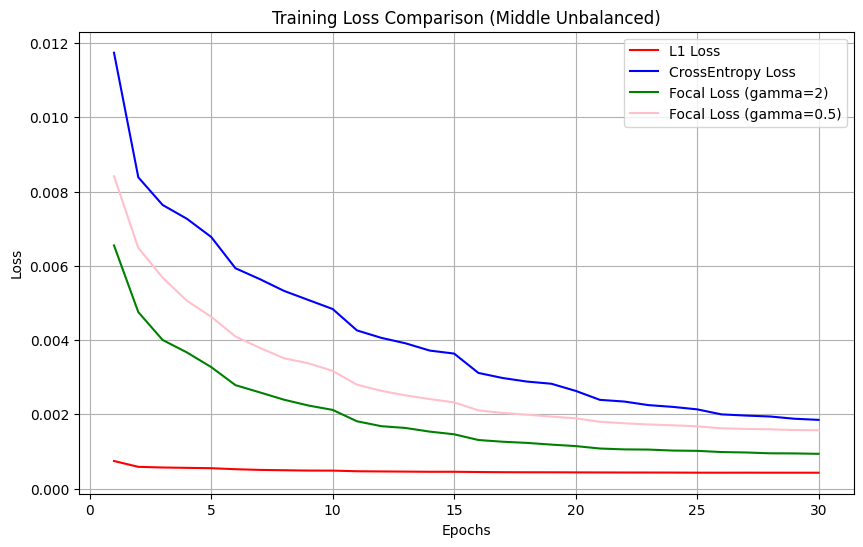

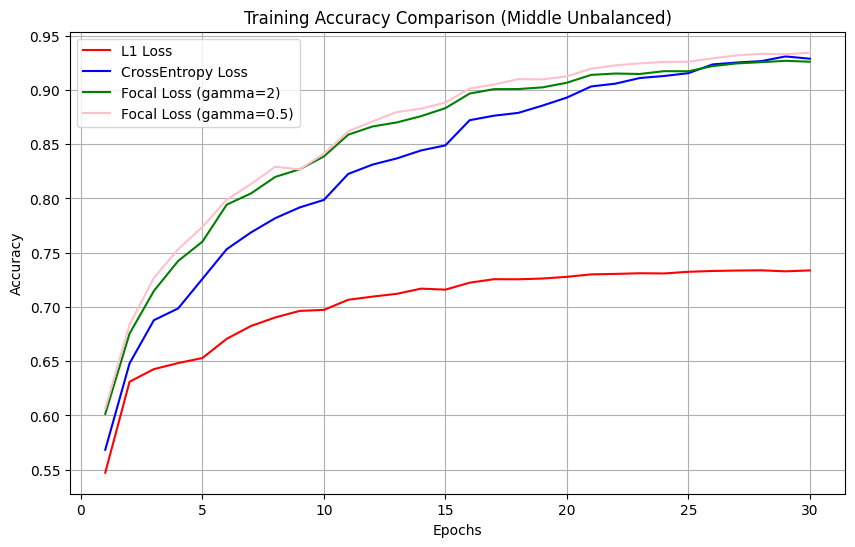

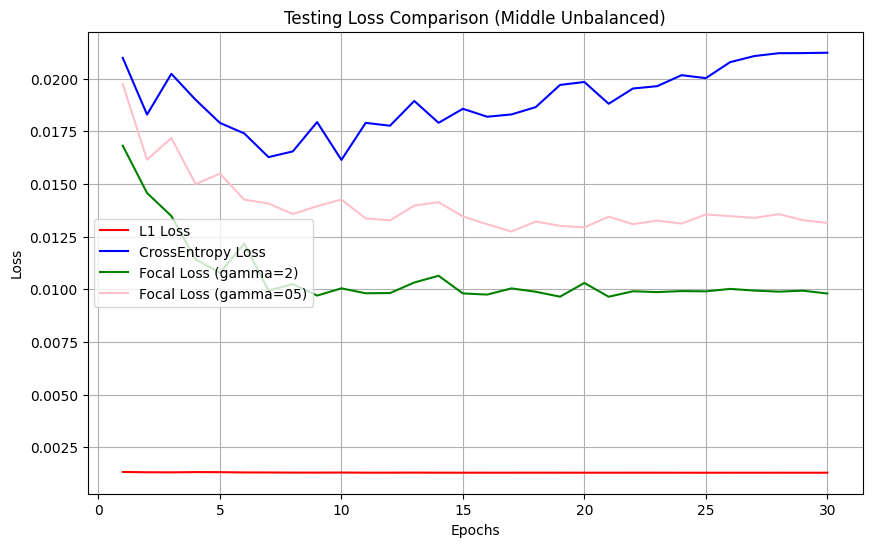

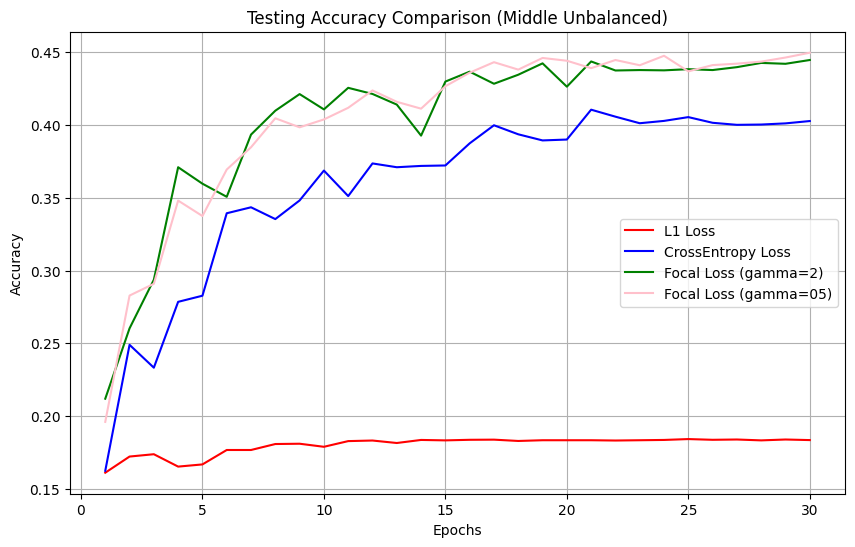

In [30]:
epochs = range(1, len(training_loss_L1) + 1)

# 训练损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_loss_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Loss Comparison (Middle Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_loss__comparison_middle.png')
plt.show()

# 训练准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, training_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, training_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, training_acc_Focal05, label='Focal Loss (gamma=0.5)', color='pink')
plt.title('Training Accuracy Comparison (Middle Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/training_accuracy_comparison_middle.png')
plt.show()

# 测试损失对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_loss_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_loss_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_loss_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_loss_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Loss Comparison (Middle Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_loss_comparison_middle.png')
plt.show()

# 测试准确率对比图
plt.figure(figsize=(10, 6))
plt.plot(epochs, testing_acc_L1, label='L1 Loss', color='red')
plt.plot(epochs, testing_acc_CE, label='CrossEntropy Loss', color='blue')
plt.plot(epochs, testing_acc_Focal2, label='Focal Loss (gamma=2)', color='green')
plt.plot(epochs, testing_acc_Focal05, label='Focal Loss (gamma=05)', color='pink')
plt.title('Testing Accuracy Comparison (Middle Unbalanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('pic/testing_accuracy_comparison_middle.png')
plt.show()

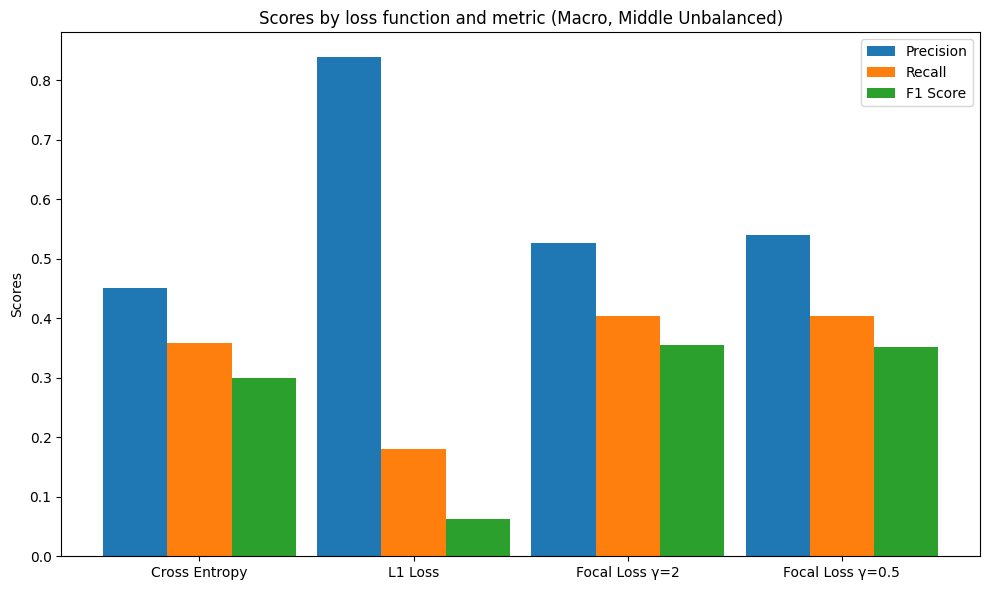

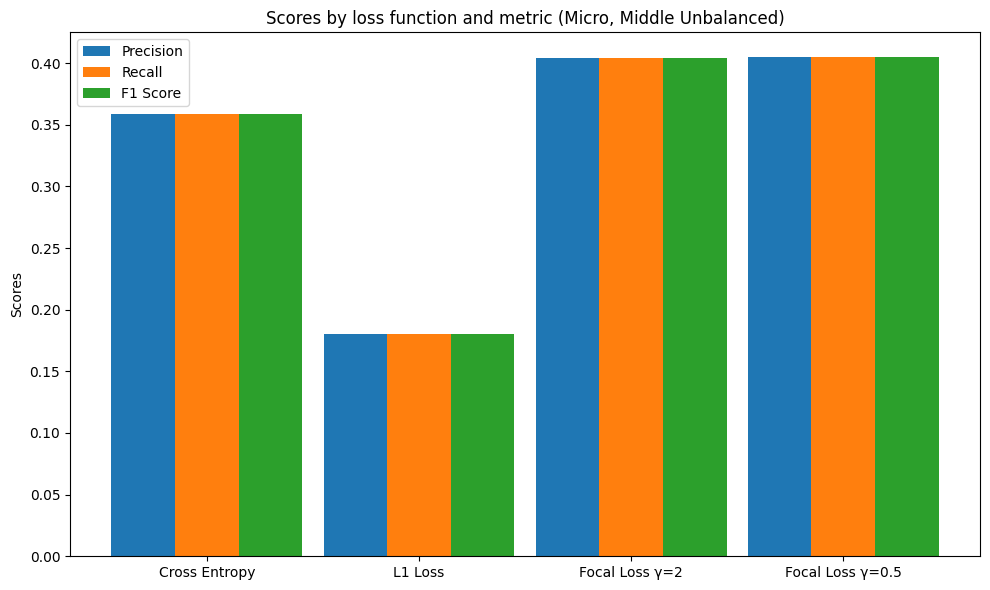

In [31]:
# Marco
x = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, macro_precisions, width, label='Precision')
rects2 = ax.bar(x, macro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, macro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Macro, Middle Unbalanced)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/macro_scores_middle.png')
plt.show()

# Micro
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, micro_precisions, width, label='Precision')
rects2 = ax.bar(x, micro_recalls, width, label='Recall')
rects3 = ax.bar(x + width, micro_f1s, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by loss function and metric (Micro, Middle Unbalanced)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig('pic/micro_scores_middle.png')
plt.show()

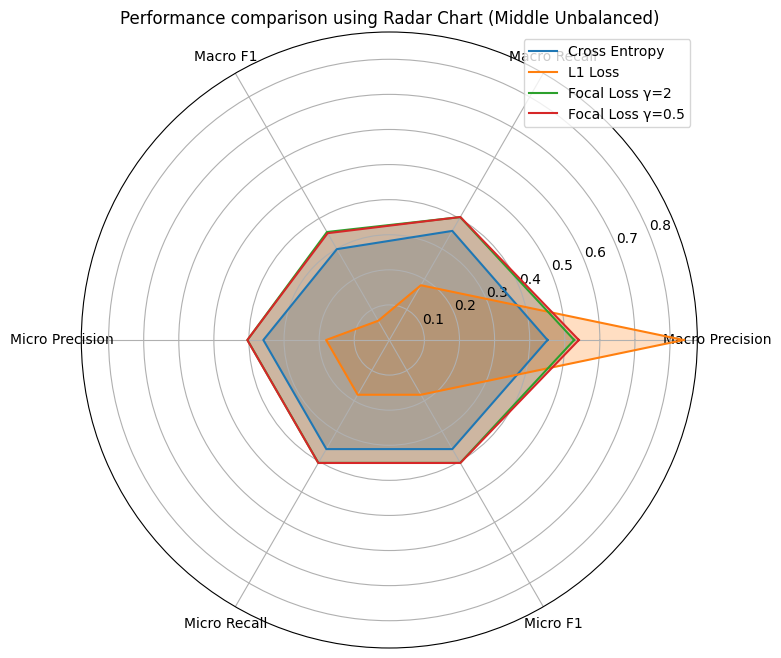

In [32]:
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1', 'Micro Precision', 'Micro Recall', 'Micro F1']
values_list = [
    [macro_precision_ce, macro_recall_ce, macro_f1_ce, micro_precision_ce, micro_recall_ce, micro_f1_ce],
    [macro_precision_l1, macro_recall_l1, macro_f1_l1, micro_precision_l1, micro_recall_l1, micro_f1_l1],
    [macro_precision_focal2, macro_recall_focal2, macro_f1_focal2, micro_precision_focal2, micro_recall_focal2, micro_f1_focal2],
    [macro_precision_focal05, macro_recall_focal05, macro_f1_focal05, micro_precision_focal05, micro_recall_focal05, micro_f1_focal05]
]

# draw the Radar Chart
N = len(metrics)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for values, label in zip(values_list, labels):
    values = np.concatenate((values, [values[0]]))  # Close the loop
    ax.plot(theta, values, label=label)
    ax.fill(theta, values, alpha=0.25)

ax.set_xticks(theta[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Performance comparison using Radar Chart (Middle Unbalanced)")
ax.legend(loc='upper right')
plt.savefig('pic/radar_middle.png')
plt.show()

